In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Evaluating text model

In [3]:
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256, 
    "emb_dim": 768,
    "n_heads": 12, 
    "n_layers": 12,
    "drop_rate": 0.1, 
    "qkv_bias": False,
}

mx.random.seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.09999999999999998)
  (trf_blocks): Sequential(
    (layers.0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(input_dims=768, output_dims=768, bias=False)
        (W_key): Linear(input_dims=768, output_dims=768, bias=False)
        (W_value): Linear(input_dims=768, output_dims=768, bias=False)
        (out_proj): Linear(input_dims=768, output_dims=768, bias=True)
        (dropout): Dropout(p=0.09999999999999998)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (layers.0): Linear(input_dims=768, output_dims=3072, bias=True)
          (layers.1): GELU()
          (layers.2): Linear(input_dims=3072, output_dims=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.09999999999999998)
    )
    (layers.1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_

In [4]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = mx.array(encoded)[None, :]
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze().tolist()
    return tokenizer.decode(flat)

In [5]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you DMVSK DMVieversseparSKseparseparseparsepar'

## Calculating the text generation loss: cross-entropy and perplexity

In [6]:
inputs = mx.array([[16833, 3626, 6100],   # ["every effort moves",
                   [40, 1107, 588]])      #  "I really like"]
targets = mx.array([[3626, 6100, 345],    # [" effort moves you"
                    [1107, 588, 11311]])  #  " really like chocolate"]

In [7]:
logits = model(mx.stop_gradient(inputs))
probas = nn.softmax(logits, axis=-1)
probas, probas.shape

(array([[[1.08953e-05, 1.54743e-05, 5.29234e-05, ..., 1.1125e-05, 1.47884e-05, 1.07763e-05],
         [1.16216e-05, 2.01177e-05, 6.33257e-05, ..., 1.26e-05, 8.72894e-06, 1.6723e-05],
         [1.16933e-05, 2.81832e-05, 5.13414e-05, ..., 1.21165e-05, 1.2233e-05, 1.76848e-05]],
        [[1.78601e-05, 1.22162e-05, 1.27557e-05, ..., 2.22658e-05, 2.96495e-05, 3.25666e-06],
         [1.47091e-05, 1.38527e-05, 1.48364e-05, ..., 2.22301e-05, 2.02625e-05, 4.84638e-06],
         [1.36925e-05, 1.54772e-05, 1.60843e-05, ..., 2.20074e-05, 1.94253e-05, 6.39406e-06]]], dtype=float32),
 (2, 3, 50257))

In [8]:
token_ids = mx.argmax(probas, axis=-1, keepdims=True)
token_ids

array([[[33548],
        [38162],
        [38162]],
       [[16272],
        [16272],
        [16272]]], dtype=uint32)

In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


Targets batch 1:  effort moves you
Outputs batch 1: 501YRYR


In [10]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: array([1.9632e-05, 1.4344e-05, 1.21008e-05], dtype=float32)
Text 2: array([1.32206e-05, 6.42074e-06, 1.168e-05], dtype=float32)


In [11]:
# we want to maximize the log probability of the targets
log_probas = mx.log(mx.concat([target_probas_1, target_probas_2], axis=0))
log_probas

array([-10.8384, -11.1522, -11.3222, -11.2337, -11.956, -11.3576], dtype=float32)

In [12]:
avg_log_probas = mx.mean(log_probas)
avg_log_probas

array(-11.31, dtype=float32)

In [13]:
# in training, we minimize the negative log likelihood
neg_avg_log_probas = -avg_log_probas
neg_avg_log_probas

array(11.31, dtype=float32)

In [14]:
logits.flatten(0, 1).shape, targets.flatten().shape

((6, 50257), (6,))

In [15]:
loss = nn.losses.cross_entropy(logits.flatten(0, 1), targets.flatten(),
                               reduction="mean")
loss

array(11.31, dtype=float32)

In [16]:
# perplexity is exp of the cross-entropy loss
perplexity = mx.exp(loss)
perplexity

array(81635.5, dtype=float32)

## Calculating the training and validation set losses

In [17]:
with open("../ch02/the-verdict.txt", "r") as f:
    text_data = f.read()

In [18]:
text_data[:99], text_data[-99:]

('I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no ',
 'it for me! The Strouds stand alone, and happen once--but there\'s no exterminating our kind of art."')

In [19]:
total_characters, total_tokens = len(text_data), len(tokenizer.encode(text_data))
total_characters, total_tokens

(20479, 5145)

In [20]:
from previous_chapters import GPTDatasetV1
tokenizer = tiktoken.get_encoding("gpt2")

train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

mx.random.seed(123)
train_loader = GPTDatasetV1(
    train_data,
    tokenizer,
    GPT_CONFIG_124M["context_length"],
    GPT_CONFIG_124M["context_length"],
    batch_size=2,
    drop_last=True,
    shuffle=True,
)
val_loader = GPTDatasetV1(
    val_data,
    tokenizer,
    GPT_CONFIG_124M["context_length"],
    GPT_CONFIG_124M["context_length"],
    batch_size=2,
    drop_last=True,
    shuffle=True,
)

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the trainig loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")
    
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

print("Train loader:")
train_tokens = 0
for ex in iter(train_loader):
    print(ex['input_ids'].shape, ex['target_ids'].shape)
    train_tokens += ex['input_ids'].size

val_tokens = 0
print("\nValidation loader:")
for ex in iter(val_loader):
    print(ex['input_ids'].shape, ex['target_ids'].shape)
    val_tokens += ex['input_ids'].size

train_tokens, val_tokens

Train loader:
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)

Validation loader:
(2, 256) (2, 256)


(4608, 512)

In [21]:
def compute_ce_loss(logits, target):
    loss = nn.losses.cross_entropy(logits.flatten(0, 1), target.flatten(), 
                                   reduction="mean")
    return loss

def calc_loss_batch(input_batch, target_batch, model, no_grad, device=None):
    input_batch, target_batch = mx.array(input_batch), mx.array(target_batch)

    if no_grad:
        input_batch = mx.stop_gradient(input_batch)
    logits = model(input_batch)
    batch_step_fn = nn.value_and_grad(model, compute_ce_loss)
    loss, grad = batch_step_fn(logits, target_batch)
    return loss, grad

def calc_loss_loader(data_loader, model, no_grad, device=None, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, ex in enumerate(iter(data_loader)):
        if i < num_batches:
            loss, _ = calc_loss_batch(ex['input_ids'], ex['target_ids'], model, no_grad, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches    

In [22]:
mx.random.seed(123)
train_loss = calc_loss_loader(train_loader, model, True)
val_loss = calc_loss_loader(val_loader, model, True)
train_loss, val_loss

(11.026213222079807, 11.002269744873047)

# Training an LLM

In [23]:
# TODO: set device for model and data functions
mx.default_device()

Device(gpu, 0)

In [24]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, 0

    for epoch in range(num_epochs):
        # mx.eval(model.parameters())
        model.train()
        for batch in iter(train_loader):
            input_batch, target_batch = batch['input_ids'], batch['target_ids']
            loss, grads = calc_loss_batch(input_batch, target_batch, model, no_grad=False)
            optimizer.update(model, grads)
            # Force a graph evaluation
            # mx.eval(model.parameters(), optimizer.state)
            # mx.eval(model.state)
            mx.eval(loss, [model.state, optimizer.state])
            tokens_seen += input_batch.size
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1}, step {global_step:06d}: "
                      f"train loss {train_loss:.3f}, val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
        # print(f"Epoch {epoch+1}, Loss: {loss.item():.3f}, Tokens seen: {tokens_seen}")
    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    train_loss = calc_loss_loader(train_loader, model, True, device, eval_iter)
    val_loss = calc_loss_loader(val_loader, model, True, device, eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer)
    token_ids = generate_text_simple(
        model=model,
        idx=mx.stop_gradient(encoded),
        max_new_tokens=50,
        context_size=context_size,
    )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [25]:
mx.random.seed(123)
model = GPTModel(GPT_CONFIG_124M)
optimizer = optim.AdamW(learning_rate=4e-4, weight_decay=1e-1)

# TODO: training is too slow, needs investigation.
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, None, 
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Epoch 1, step 000005: train loss 11.036, val loss 11.002
Every effort moves you DMVSK DMVieversseparSKseparseparseparseparseparseparseparseparSKSKSK hrsSK hrsSKSKSK hrsSKSKSKSKSK hrsSK hrsSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSK
Epoch 2, step 000010: train loss 11.034, val loss 11.002
Epoch 2, step 000015: train loss 11.031, val loss 11.002
Every effort moves you DMVSK DMVieversseparSKseparseparseparseparseparseparseparseparSKSKSK hrsSK hrsSKSKSK hrsSKSKSKSKSK hrsSK hrsSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSK
Epoch 3, step 000020: train loss 11.026, val loss 11.002
Epoch 3, step 000025: train loss 11.021, val loss 11.002
Every effort moves you DMVSK DMVieversseparSKseparseparseparseparseparseparseparseparSKSKSK hrsSK hrsSKSKSK hrsSKSKSKSKSK hrsSK hrsSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSKSK
Epoch 4, step 000030: train loss 11.021, val loss 11.001
Epoch 4, step 000035: train loss 11.028, val loss 11.001
Every effort moves you DMVSK DMVieversseparSKseparseparseparseparseparseparseparseparSKSKSK hrsSK

# Decoding strategies to control randomness

In [26]:
# generating the same text output
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("output text:\n", token_ids_to_text(token_ids, tokenizer))

output text:
 Every effort moves you DMVSK DMVieversseparSKseparseparseparseparseparseparseparseparSKSKSK hrsSK hrsSKSKSK hrsSK


In [27]:
# temperature scaling and sample from the distribution, instead of using argmax
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# suppose input is "every effort moves you", and the LLM returns the following logits for the next token:
next_token_logits = mx.array([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probas = nn.softmax(next_token_logits, axis=-1)
next_token_id = mx.argmax(probas).item()
inverse_vocab[next_token_id]

'forward'

In [28]:
mx.random.seed(123)
sample = [mx.random.categorical(probas, num_samples=1).item() for _ in range(1000)]
sampled_ids = mx.zeros(len(vocab)).at[sample].add(1)
for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")

107.0 x closer
87.0 x every
98.0 x effort
177.0 x forward
100.0 x inches
93.0 x moves
98.0 x pizza
137.0 x toward
103.0 x you


In [ ]:
# temperature sampling
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return nn.softmax(scaled_logits, axis=0)

temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

IndexError: SmallVector out of range.

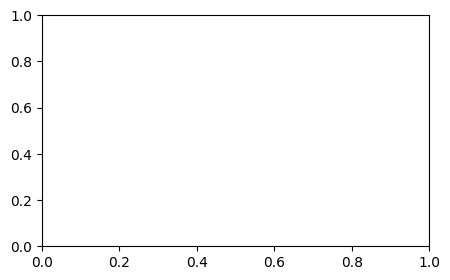

In [31]:
x = mx.arange(len(vocab))
bar_width = 0.15

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature={T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()

In [50]:
# top-k sampling
top_k = 3
top_logits = mx.topk(next_token_logits, top_k)
top_pos = mx.argsort(next_token_logits)[::-1][:top_k]
top_logits, top_pos

(array([4.51, 6.28, 6.75], dtype=float32), array([3, 7, 0], dtype=uint32))

In [51]:
new_logits = mx.where(
    next_token_logits < top_logits.min(),
    -mx.inf,
    next_token_logits,
)
new_logits

array([4.51, -inf, -inf, ..., -inf, 6.28, -inf], dtype=float32)

In [63]:
# updated generation function with temperature and top-k sampling
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        logits = model(mx.stop_gradient(idx_cond))
        logits = logits[:, -1, :]

        # top_k filtering
        if top_k is not None:
            top_logits = mx.topk(logits, top_k)
            min_val = top_logits.min()
            logits = mx.where(logits < min_val, -mx.inf, logits)
        
        # temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
            probs = mx.softmax(logits, axis=-1)
            idx_next = mx.random.categorical(probs, num_samples=1)
        # otherwise, use the highest logit value
        else:
            idx_next = mx.argmax(logits, axis=-1, keepdims=True)

        if idx_next.item() == eos_id:
            break
        idx = mx.concat([idx, idx_next], axis=1)
    return idx


In [64]:
mx.random.seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you783 hallmark Cherpass indicator identifies sector lair riteictionaryAlong Hampshirelaughs sons mocked
